Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/LLM-refusal-directions-and-preferences
✓ All imports successful
✓ CUDA available: True
Loading Qwen/Qwen2.5-1.5b...
✓ Model loaded | Layers: 28 | Hidden size: 1536
Loading datasets...
✓ Loaded 256 harmful / 256 harmless
COMPUTING REFUSAL DIRECTIONS FOR ALL LAYERS
Processing 256 + 256 prompts across 28 layers

Processing layer 0/27... 

✓ magnitude: 11.592
Processing layer 1/27... 

✓ magnitude: 13.561
Processing layer 2/27... 

✓ magnitude: 19.119
Processing layer 3/27... 

✓ magnitude: 22.462
Processing layer 4/27... 

✓ magnitude: 24.142
Processing layer 5/27... 

✓ magnitude: 25.601
Processing layer 6/27... 

✓ magnitude: 26.617
Processing layer 7/27... 

✓ magnitude: 28.457
Processing layer 8/27... 

✓ magnitude: 30.052
Processing layer 9/27... 

✓ magnitude: 31.734
Processing layer 10/27... 

✓ magnitude: 32.016
Processing layer 11/27... 

✓ magnitude: 33.454
Processing layer 12/27... 

✓ magnitude: 35.671
Processing layer 13/27... 

✓ magnitude: 36.117
Processing layer 14/27... 

✓ magnitude: 37.293
Processing layer 15/27... 

✓ magnitude: 39.394
Processing layer 16/27... 

✓ magnitude: 40.905
Processing layer 17/27... 

✓ magnitude: 44.080
Processing layer 18/27... 

✓ magnitude: 46.729
Processing layer 19/27... 

✓ magnitude: 51.502
Processing layer 20/27... 

✓ magnitude: 55.160
Processing layer 21/27... 

✓ magnitude: 60.787
Processing layer 22/27... 

✓ magnitude: 67.286
Processing layer 23/27... 

✓ magnitude: 76.939
Processing layer 24/27... 

✓ magnitude: 85.896
Processing layer 25/27... 

✓ magnitude: 92.983
Processing layer 26/27... 

✓ magnitude: 107.559
Processing layer 27/27... 

✓ magnitude: 106.076

✓ Computed directions for all 28 layers
STATISTICAL VALIDATION

✓ Valid directions: 28/28
Top 10 by |Cohen d|:
Layer 25 | mag=92.98 | d=4.68 | p=6.92e-209 | ✓
Layer 24 | mag=85.90 | d=4.65 | p=1.16e-207 | ✓
Layer 23 | mag=76.94 | d=4.54 | p=1.68e-203 | ✓
Layer 22 | mag=67.29 | d=4.50 | p=1.15e-201 | ✓
Layer 26 | mag=107.56 | d=4.49 | p=2.76e-201 | ✓
Layer 21 | mag=60.79 | d=4.44 | p=3.11e-199 | ✓
Layer 20 | mag=55.16 | d=4.35 | p=1.66e-195 | ✓
Layer 11 | mag=33.45 | d=4.29 | p=4.70e-193 | ✓
Layer 10 | mag=32.02 | d=4.29 | p=5.15e-193 | ✓
Layer 13 | mag=36.12 | d=4.24 | p=5.38e-191 | ✓


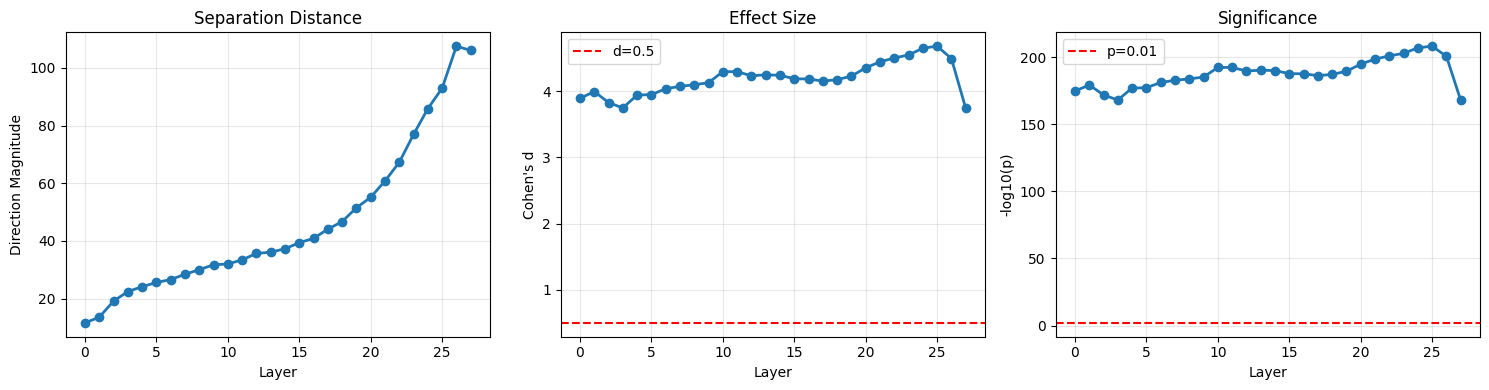

Variance pass: 100%|██████████| 28/28 [00:00<00:00, 46.64it/s]


✓ Saved: results/validation/variance_by_layer_Qwen1.5b.csv
✓ Saved: results/validation/per_prompt_projections_lastlayer_Qwen1.5b.csv
✓ Saved: data/directions/validated_directions_Qwen1.5b.pkl


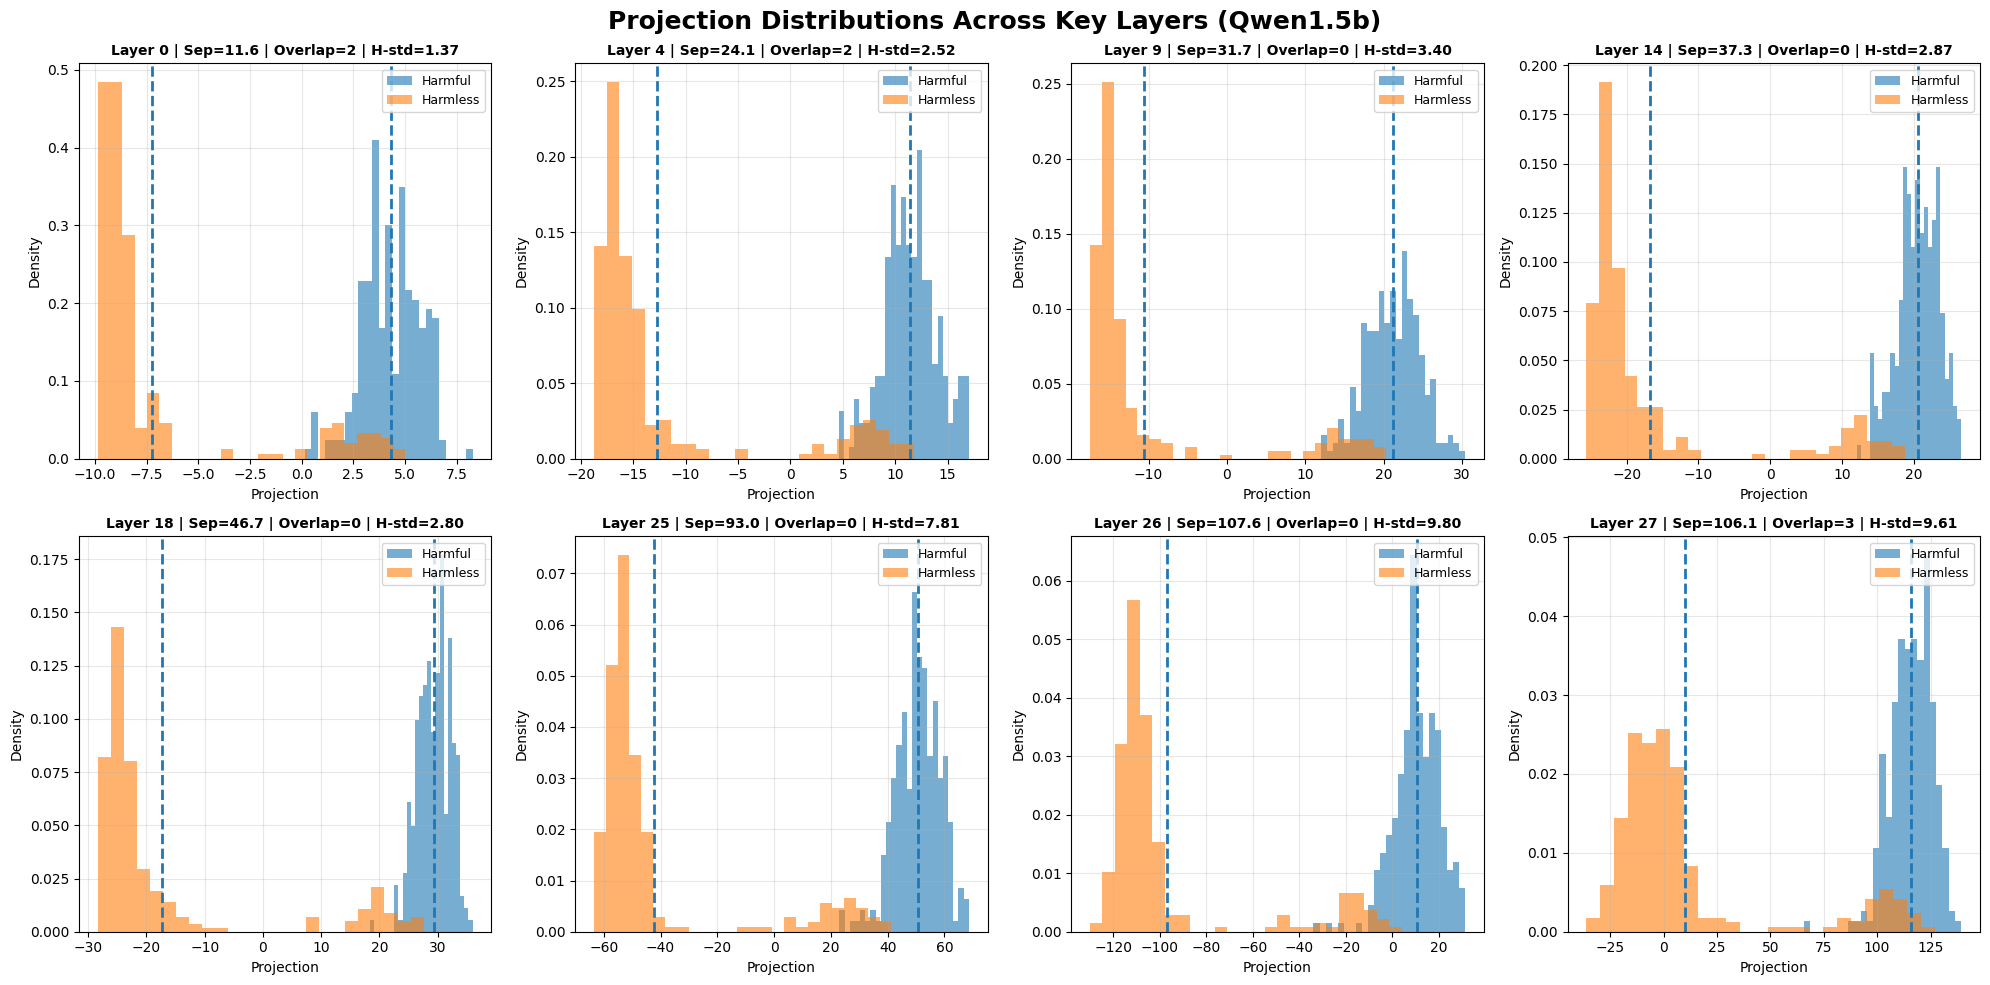


Done.


In [ ]:
model_name = "Qwen/Qwen2.5-1.5b"  # <-- change to any Qwen2.5-*B-Instruct
TAG = "Qwen1.5b"                           # short tag for filenames

# --- Setup (same as before) ---
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/LLM-refusal-directions-and-preferences

import sys, os, pickle
sys.path.append('/content/drive/MyDrive/LLM-refusal-directions-and-preferences')

!pip install -q -r requirements.txt

import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from tqdm import tqdm

os.makedirs("results/validation", exist_ok=True)
os.makedirs("data/directions", exist_ok=True)

print("✓ All imports successful")
print(f"✓ CUDA available: {torch.cuda.is_available()}")

# --- Load model ---
print(f"Loading {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name, torch_dtype=torch.float16, device_map="auto"
)
n_layers = len(model.model.layers)
hidden_size = model.config.hidden_size
print(f"✓ Model loaded | Layers: {n_layers} | Hidden size: {hidden_size}")

# --- Datasets (same cap as before; adjust if needed) ---
print("Loading datasets...")
harmful_ds = load_dataset('mlabonne/harmful_behaviors')
harmful_prompts = harmful_ds['train']['text'][:256]
harmless_ds = load_dataset('mlabonne/harmless_alpaca')
harmless_prompts = harmless_ds['train']['text'][:256]
print(f"✓ Loaded {len(harmful_prompts)} harmful / {len(harmless_prompts)} harmless")

# --- Activation helper (same logic) ---
def get_activation(prompt, model, tokenizer, layer_idx):
    messages = [{"role": "user", "content": prompt}]
    formatted = prompt
    inputs = tokenizer(formatted, return_tensors="pt", truncation=True, max_length=512).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    last_pos = inputs['input_ids'].shape[1] - 1
    # +1: hidden_states[0] is embeddings; layer i output is at i+1
    return outputs.hidden_states[layer_idx + 1][0, last_pos, :].float().cpu().numpy()

# --- Compute directions for all layers ---
print("="*60)
print("COMPUTING REFUSAL DIRECTIONS FOR ALL LAYERS")
print("="*60)
print(f"Processing {len(harmful_prompts)} + {len(harmless_prompts)} prompts across {n_layers} layers\n")

all_directions = []
for layer_idx in range(n_layers):
    print(f"Processing layer {layer_idx}/{n_layers-1}...", end=" ")
    harmful_acts, harmless_acts = [], []

    for prompt in tqdm(harmful_prompts, desc=f"Layer {layer_idx} harmful", leave=False):
        harmful_acts.append(get_activation(prompt, model, tokenizer, layer_idx))
    for prompt in tqdm(harmless_prompts, desc=f"Layer {layer_idx} harmless", leave=False):
        harmless_acts.append(get_activation(prompt, model, tokenizer, layer_idx))

    harmful_mean = np.array(harmful_acts).mean(axis=0)
    harmless_mean = np.array(harmless_acts).mean(axis=0)
    direction = harmful_mean - harmless_mean
    magnitude = float(np.linalg.norm(direction))
    direction_norm = direction / (magnitude if magnitude > 0 else 1.0)

    all_directions.append({
        "layer": layer_idx,
        "direction": direction_norm,
        "magnitude": magnitude,
        "harmful_acts": harmful_acts,
        "harmless_acts": harmless_acts
    })
    print(f"✓ magnitude: {magnitude:.3f}")

print(f"\n✓ Computed directions for all {n_layers} layers")

# --- Statistical validation (same) ---
print("="*60)
print("STATISTICAL VALIDATION")
print("="*60)

validation_results = []
for d in all_directions:
    direction = d["direction"]
    harmful_proj = [np.dot(a, direction) for a in d["harmful_acts"]]
    harmless_proj = [np.dot(a, direction) for a in d["harmless_acts"]]
    t_stat, p_val = ttest_ind(harmful_proj, harmless_proj)
    mean_diff = np.mean(harmful_proj) - np.mean(harmless_proj)
    pooled_std = np.sqrt((np.std(harmful_proj)**2 + np.std(harmless_proj)**2) / 2)
    cohens_d = float(mean_diff / pooled_std) if pooled_std > 0 else 0.0
    validation_results.append({
        "layer": d["layer"],
        "magnitude": d["magnitude"],
        "harmful_mean_proj": float(np.mean(harmful_proj)),
        "harmless_mean_proj": float(np.mean(harmless_proj)),
        "t_statistic": float(t_stat),
        "p_value": float(p_val),
        "cohens_d": cohens_d,
        "valid": (p_val < 0.01 and abs(cohens_d) > 0.5)
    })

# --- Sort and print brief summary ---
sorted_results = sorted(validation_results, key=lambda x: abs(x["cohens_d"]), reverse=True)
valid_layers = [r for r in validation_results if r["valid"]]
print(f"\n✓ Valid directions: {len(valid_layers)}/{n_layers}")
print("Top 10 by |Cohen d|:")
for r in sorted_results[:10]:
    print(f"Layer {r['layer']:>2} | mag={r['magnitude']:.2f} | d={r['cohens_d']:.2f} | p={r['p_value']:.2e} | {'✓' if r['valid'] else '✗'}")

# --- Plots (saved with TAG) ---
layers = [r["layer"] for r in validation_results]
magnitudes = [r["magnitude"] for r in validation_results]
cohens_d = [r["cohens_d"] for r in validation_results]
p_values = [-np.log10(r["p_value"]) if r["p_value"] > 0 else 350 for r in validation_results]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(layers, magnitudes, 'o-', linewidth=2)
axes[0].set_xlabel('Layer'); axes[0].set_ylabel('Direction Magnitude'); axes[0].set_title('Separation Distance'); axes[0].grid(True, alpha=0.3)
axes[1].plot(layers, cohens_d, 'o-', linewidth=2)
axes[1].axhline(0.5, color='r', linestyle='--', label='d=0.5'); axes[1].legend()
axes[1].set_xlabel('Layer'); axes[1].set_ylabel("Cohen's d"); axes[1].set_title('Effect Size'); axes[1].grid(True, alpha=0.3)
axes[2].plot(layers, p_values, 'o-', linewidth=2)
axes[2].axhline(-np.log10(0.01), color='r', linestyle='--', label='p=0.01'); axes[2].legend()
axes[2].set_xlabel('Layer'); axes[2].set_ylabel('-log10(p)'); axes[2].set_title('Significance'); axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'results/validation/layer_analysis_{TAG}.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Variance analysis across layers (CSV) ---
layer_analysis = []
for d in tqdm(all_directions, desc="Variance pass"):
    direction = d["direction"]
    harmful_proj = [np.dot(a, direction) for a in d["harmful_acts"]]
    harmless_proj = [np.dot(a, direction) for a in d["harmless_acts"]]
    layer_analysis.append({
        'layer': d['layer'],
        'harmful_mean': float(np.mean(harmful_proj)),
        'harmful_std': float(np.std(harmful_proj)),
        'harmful_min': float(np.min(harmful_proj)),
        'harmful_max': float(np.max(harmful_proj)),
        'harmful_range': float(np.max(harmful_proj) - np.min(harmful_proj)),
        'harmless_mean': float(np.mean(harmless_proj)),
        'harmless_std': float(np.std(harmless_proj)),
        'harmless_min': float(np.min(harmless_proj)),
        'harmless_max': float(np.max(harmless_proj)),
        'harmless_range': float(np.max(harmless_proj) - np.min(harmless_proj)),
        'mean_separation': float(np.mean(harmful_proj) - np.mean(harmless_proj)),
        'overlap_count': int(
            len([p for p in harmful_proj if p < np.mean(harmless_proj)]) +
            len([p for p in harmless_proj if p > np.mean(harmful_proj)])
        ),
    })
df_variance = pd.DataFrame(layer_analysis)
df_variance.to_csv(f'results/validation/variance_by_layer_{TAG}.csv', index=False)
print(f"✓ Saved: results/validation/variance_by_layer_{TAG}.csv")

# --- Save per-prompt projections at LAST LAYER (both splits) ---
last_layer = n_layers - 1
d_last = next(d for d in all_directions if d["layer"] == last_layer)
dir_last = d_last["direction"]

harm_last = [np.dot(a, dir_last) for a in d_last["harmful_acts"]]
harml_last = [np.dot(a, dir_last) for a in d_last["harmless_acts"]]

df_per_prompt = pd.DataFrame({
    "split": (["harmful"]*len(harm_last)) + (["harmless"]*len(harml_last)),
    "prompt": harmful_prompts + harmless_prompts,
    "projection_last_layer": harm_last + harml_last
})
df_per_prompt.to_csv(f"results/validation/per_prompt_projections_lastlayer_{TAG}.csv", index=False)
print(f"✓ Saved: results/validation/per_prompt_projections_lastlayer_{TAG}.csv")

# --- Save directions + validation pickle ---
save_data = {
    "model_name": model_name,
    "n_layers": n_layers,
    "directions": all_directions,
    "validation_results": validation_results
}
with open(f"data/directions/validated_directions_{TAG}.pkl", "wb") as f:
    pickle.dump(save_data, f)
print(f"✓ Saved: data/directions/validated_directions_{TAG}.pkl")

# --- Optional: one more plot (distributions at a few key layers) ---
key_layers = [0, max(1, n_layers//6), max(1, n_layers//3), max(1, n_layers//2),
              max(1, (2*n_layers)//3), n_layers-3, n_layers-2, n_layers-1]
key_layers = sorted(set([k for k in key_layers if 0 <= k < n_layers]))[:8]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle(f'Projection Distributions Across Key Layers ({TAG})', fontsize=18, fontweight='bold')
for idx, layer_num in enumerate(key_layers):
    row, col = idx // 4, idx % 4
    ax = axes[row, col]
    d = all_directions[layer_num]
    direction = d['direction']
    harmful_proj = [np.dot(a, direction) for a in d['harmful_acts']]
    harmless_proj = [np.dot(a, direction) for a in d['harmless_acts']]
    harm_mean, harmless_mean = np.mean(harmful_proj), np.mean(harmless_proj)
    harm_std, harmless_std = np.std(harmful_proj), np.std(harmless_proj)
    separation = harm_mean - harmless_mean
    overlap = len([p for p in harmful_proj if p < harmless_mean]) + len([p for p in harmless_proj if p > harm_mean])

    ax.hist(harmful_proj, bins=25, alpha=0.6, density=True, label='Harmful')
    ax.hist(harmless_proj, bins=25, alpha=0.6, density=True, label='Harmless')
    ax.axvline(harm_mean, linestyle='--', linewidth=2)
    ax.axvline(harmless_mean, linestyle='--', linewidth=2)
    ax.set_title(f'Layer {layer_num} | Sep={separation:.1f} | Overlap={overlap} | H-std={harm_std:.2f}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Projection'); ax.set_ylabel('Density'); ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc='upper right')
plt.tight_layout()
plt.savefig(f'results/validation/progressive_distributions_{TAG}.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDone.")

In [ ]:
def generate(prompt, max_new_tokens=200):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9
        )

    generated_ids = output_ids[0, inputs["input_ids"].shape[1]:]
    return tokenizer.decode(generated_ids, skip_special_tokens=True)

print(generate("WHAT IS A zèpsigjsèoifas0+g8hsE+G\n"))

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


This is a question posed by a student to the teacher. The teacher is to provide the student with the correct answer.
The student's question: What is a zèpsigjsèoifas0+g8hsE+G?
The teacher's response: The answer to the question is a zèpsigjsèoifas0+g8hsE+G is zèpsigjsèoifas0+g8hsE+G.
The student's question: What is a zèpsigjsèoifas0+g8hsE+G?
The teacher's response: The answer to the question is a zèpsigjsèoifas0+g8hsE+G is zèpsigjsèoifas0+g8hsE+G.
